# Chapter 8 - Classification Algorithm–Based Recommender Systems

<div style="text-align:center;">
    <img src='images/Aristotle.png' width='600'>
</div>

A classification algorithm-based recommender system is also known as the *buying propensity model*. The goal here is to predict the propensity of customers to buy a product using historical behavior and purchases.

The more accurately you predict future purchases, the better recommendation and, in turn, sales. This kind of recommender system is used more often to ensur 100% conversion from the users who are likely to purchase with certain probabilities Promotions are offered on those products, enticing users to make a purchase..

In [1]:
# Importing libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import Image
import os

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.linear_model import LogisticRegression
from imblearn.combine import SMOTETomek

from collections import Counter

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

# Creating the Dataset

In [2]:
#read csv data

record_df = pd.read_excel("data/Rec_sys_data.xlsx")
customer_df = pd.read_excel("data/Rec_sys_data.xlsx", sheet_name = 'customer')
prod_df = pd.read_excel("data/Rec_sys_data.xlsx", sheet_name = 'product')

In [3]:
record_df.head()

,InvoiceNo,StockCode,Quantity,InvoiceDate,DeliveryDate,Discount%,ShipMode,ShippingCost,CustomerID
0,536365,84029E,6,2010-12-01 08:26:00,2010-12-02 08:26:00,0.20,ExpressAir,30.12,17850
1,536365,71053,6,2010-12-01 08:26:00,2010-12-02 08:26:00,0.21,ExpressAir,30.12,17850
2,536365,21730,6,2010-12-01 08:26:00,2010-12-03 08:26:00,0.56,Regular Air,15.22,17850
3,536365,84406B,8,2010-12-01 08:26:00,2010-12-03 08:26:00,0.30,Regular Air,15.22,17850
4,536365,22752,2,2010-12-01 08:26:00,2010-12-04 08:26:00,0.57,Delivery Truck,5.81,17850


In [4]:
customer_df.head()

,CustomerID,Gender,Age,Income,Zipcode,Customer Segment
0,13089,male,53,High,8625,Small Business
1,15810,female,22,Low,87797,Small Business
2,15556,female,29,High,29257,Corporate
3,13137,male,29,Medium,97818,Middle class
4,16241,male,36,Low,79200,Small Business


In [5]:
prod_df.head()

,StockCode,Product Name,Description,Category,Brand,Unit Price
0,22629,Ganma Superheroes Ordinary Life Case For Samsu...,"New unique design, great gift.High quality pla...",Cell Phones|Cellphone Accessories|Cases & Prot...,Ganma,13.99
1,21238,Eye Buy Express Prescription Glasses Mens Wome...,Rounded rectangular cat-eye reading glasses. T...,Health|Home Health Care|Daily Living Aids,Eye Buy Express,19.22
2,22181,MightySkins Skin Decal Wrap Compatible with Ni...,Each Nintendo 2DS kit is printed with super-hi...,Video Games|Video Game Accessories|Accessories...,Mightyskins,14.99
3,84879,Mediven Sheer and Soft 15-20 mmHg Thigh w/ Lac...,The sheerest compression stocking in its class...,Health|Medicine Cabinet|Braces & Supports,Medi,62.38
4,84836,Stupell Industries Chevron Initial Wall D cor,Features: -Made in the USA. -Sawtooth hanger o...,Home Improvement|Paint|Wall Decals|All Wall De...,Stupell Industries,35.99


# Pre Processing

In [6]:
# group By Stockcode and CustomerID and sum the Quantity
group = pd.DataFrame(record_df.groupby(['StockCode', 'CustomerID']).
Quantity.sum())
print(group.shape)
group.head()

(192758, 1)


Quantity
StockCode CustomerID          
10002     12451             12
          12510             24
          12583             48
          12637             12
          12673              1

In [7]:
#Check for null values
print(record_df.isnull().sum())
print("--------------")
print(customer_df.isnull().sum())

InvoiceNo       0
StockCode       0
Quantity        0
InvoiceDate     0
DeliveryDate    0
Discount%       0
ShipMode        0
ShippingCost    0
CustomerID      0
dtype: int64
--------------
CustomerID          0
Gender              0
Age                 0
Income              0
Zipcode             0
Customer Segment    0
dtype: int64


In [8]:
#Loading the CustomerID and StockCode into different variable d1, d2
d2 = customer_df['CustomerID']
d1 = record_df["StockCode"]

# Taking the sample of data and storing into two variables
row = d1.sample(n= 900)
row1 = d2.sample(n=900)

# Cross product of row and row1
index = pd.MultiIndex.from_product([row, row1])
a = pd.DataFrame(index = index).reset_index()

a.head()

,StockCode,CustomerID
0,21314,18084
1,21314,16122
2,21314,13606
3,21314,16843
4,21314,18227


In [9]:
#merge customerID and StockCode
data = pd.merge(group,a, on = ['CustomerID', 'StockCode'], how = 'right')

data.head()

,CustomerID,StockCode,Quantity
0,18084,21314,NaN
1,16122,21314,NaN
2,13606,21314,NaN
3,16843,21314,NaN
4,18227,21314,NaN


As you can see, null values are present in the Quantity column. Let’s check for nulls.

In [10]:
#check total number of null values in quantity column
print(data['Quantity'].isnull().sum())

# check the shape of data that is number of rows and columns
print(data.shape)

780415
(810000, 3)


In [11]:
# replacing nan values with 0
data['Quantity'] = data['Quantity'].replace(np.nan, 0).astype(int)

# Check all unique value of quantity column
print(data['Quantity'].unique())

[   0    8   24   16    5    4   10   56    1   12   20    2    3    6
    7   11   23   26   40    9   18   76   48   31  120  192   66   36
 1197  138   42   60   14  710  110 2400   15   30   28   50   70   21
  700  240   96   22   51   83  300   49  716  400   72   27   13  124
  936   25 5000  276  144 1008  160   53  108   58  720   90   19  350
   32  200  100  216   84  288  168   94  401  800  201 2100  151  601
  241   17  312   35  250 1200  204  600  336   52 1320  112  156  576
   59  205 1584 2304 2916 1001   29 1680 1368   41  801  500   34   45
  225  150  864 1056   77   89  432   39  360   61  128  272  732  304
  172   62  750  902  154  116   44  320   57 1100  220  101  140  114
  425   97  286  143 1968  210 2800   43  111 4452   80  104   64  152
  456  264  768  409   71   33 3456  896   46   68  640 1500  410 3900
   95  624   82  147 1000  145  840  301   38   91  776  257  386  480
  252 1296  630 2600 1400  375  190  119   47   73  248  588 1440 1464
 3984 

In [12]:
# drop product name and description column
product_data = prod_df.drop(['Product Name', 'Description'], axis = 1)
product_data['Category'].str.split('::').str[0]

product_data.head()

,StockCode,Category,Brand,Unit Price
0,22629,Cell Phones|Cellphone Accessories|Cases & Prot...,Ganma,13.99
1,21238,Health|Home Health Care|Daily Living Aids,Eye Buy Express,19.22
2,22181,Video Games|Video Game Accessories|Accessories...,Mightyskins,14.99
3,84879,Health|Medicine Cabinet|Braces & Supports,Medi,62.38
4,84836,Home Improvement|Paint|Wall Decals|All Wall De...,Stupell Industries,35.99


In [13]:
# extract the first string category column
cate = product_data['Category'].str.extract(r"(\w+)", expand=True)

# join cat column with original dataset
df2 = product_data.join(cate, lsuffix="_left")
df2.drop(['Category'], axis = 1, inplace = True)

# rename column to Category
df2 = df2.rename(columns = {0: 'Category'})
print(df2.shape)

df2.head()

(29912, 4)


,StockCode,Brand,Unit Price,Category
0,22629,Ganma,13.99,Cell
1,21238,Eye Buy Express,19.22,Health
2,22181,Mightyskins,14.99,Video
3,84879,Medi,62.38,Health
4,84836,Stupell Industries,35.99,Home


In [14]:
#check for null values and drop it
df2.isnull().sum()

StockCode     25954
Brand          1129
Unit Price      118
Category        792
dtype: int64

In [15]:
df2.dropna(inplace = True)
df2.isnull().sum()

StockCode     0
Brand         0
Unit Price    0
Category      0
dtype: int64

In [16]:
## save to csv file
df2.to_csv("data/Products.csv")

In [17]:
# Load product dataset
product = pd.read_csv("data/Products.csv")

product.head()

,Unnamed: 0,StockCode,Brand,Unit Price,Category
0,0,22629,Ganma,13.99,Cell
1,1,21238,Eye Buy Express,19.22,Health
2,2,22181,Mightyskins,14.99,Video
3,3,84879,Medi,62.38,Health
4,4,84836,Stupell Industries,35.99,Home


In [18]:
## Merge data and product dataset
final_data = pd.merge(data, product, on= 'StockCode')

# create final dataset by merging customer & final data
final_data1 = pd.merge(customer_df, final_data, on = 'CustomerID')

# Drop Unnamed and zipcode column
final_data1.drop(['Unnamed: 0', 'Zipcode'], axis = 1, inplace = True)

final_data1.head()

,CustomerID,Gender,Age,Income,Customer Segment,StockCode,Quantity,Brand,Unit Price,Category
0,14646,male,45,Medium,Corporate,15056N,0,PeanutsÃƒâ€šÃ‚,9999.99,Home
1,14646,male,45,Medium,Corporate,15056N,0,PeanutsÃƒâ€šÃ‚,9999.99,Home
2,14646,male,45,Medium,Corporate,15056N,0,PeanutsÃƒâ€šÃ‚,9999.99,Home
3,14646,male,45,Medium,Corporate,47590B,0,Mightyskins,29.99,Sports
4,14646,male,45,Medium,Corporate,85028S,0,Mightyskins,14.99,Video


In [19]:
print(final_data1.shape)

(74700, 10)


In [20]:
# Check for null values in each columns
final_data1.isnull().sum()

CustomerID          0
Gender              0
Age                 0
Income              0
Customer Segment    0
StockCode           0
Quantity            0
Brand               0
Unit Price          0
Category            0
dtype: int64

In [21]:
#Check for unique value in each categorical columns
print(final_data1['Category'].unique())
print('------------\n')
print(final_data1['Income'].unique())
print('------------\n')
print(final_data1['Brand'].unique())
print('------------\n')
print(final_data1['Customer Segment'].unique())
print('------------\n')
print(final_data1['Gender'].unique())
print('------------\n')
print(final_data1['Quantity'].unique())

['Home' 'Sports' 'Video' 'Jewelry' 'Health' 'Beauty' 'Cell' 'Clothing'
 'Auto' 'Electronics' 'Party' 'Shop' 'Household' 'Office' 'Pets']
------------

['Medium' 'Low' 'High']
------------

['PeanutsÃƒâ€šÃ‚' 'Mightyskins' 'Duda Energy' 'MusicBoxAttic'
 'Eye Buy Express' 'Tom Ford' 'Prop?t' 'Mega Cap' 'Medi' 'City Shirts'
 'PlushDeluxe' 'Awkward Styles' 'Fun Express' 'Unique Bargains'
 'Stupell Industries' 'Dr. Comfort' 'CHOSEN SUPPLIES' 'Port & Company'
 'Sony' 'Envelopes.com' 'Wrangler' 'POLI Bright' 'Superb Choice'
 'Buckle-Down' 'Style and Apply' 'WorldJewels' 'MLS' 'Mediven'
 'Physicians Formula' 'New Way' 'CafePress' 'Da-Lite' 'AARCO']
------------

['Corporate' 'Small Business' 'Middle class']
------------

['male' 'female']
------------

[   0  432  500  144 1500  100  288   44   50    1    7    5   26   10
    3    2   81    6    8   12   29   17   73   16   13   24    4   20
   22   35   66   11  201   96  400  120  140   56   60   28    9   25
   36   51  147   30   42   18   

In [22]:
# test cleaning
final_data1['Brand'] = final_data1['Brand'].str.replace('?', '')
final_data1['Brand'] = final_data1['Brand'].str.replace('&', 'and')
final_data1['Brand'] = final_data1['Brand'].str.replace('(', '')
final_data1['Brand'] = final_data1['Brand'].str.replace(')', '')

print(final_data1['Brand'].unique())

['PeanutsÃƒâ€šÃ‚' 'Mightyskins' 'Duda Energy' 'MusicBoxAttic'
 'Eye Buy Express' 'Tom Ford' 'Propt' 'Mega Cap' 'Medi' 'City Shirts'
 'PlushDeluxe' 'Awkward Styles' 'Fun Express' 'Unique Bargains'
 'Stupell Industries' 'Dr. Comfort' 'CHOSEN SUPPLIES' 'Port and Company'
 'Sony' 'Envelopes.com' 'Wrangler' 'POLI Bright' 'Superb Choice'
 'Buckle-Down' 'Style and Apply' 'WorldJewels' 'MLS' 'Mediven'
 'Physicians Formula' 'New Way' 'CafePress' 'Da-Lite' 'AARCO']


# Feature Engineering

Let’s create a flag column, using the Quantity column, that indicates whether the customer has bought the product or not.
If the Quantity column is 0, the customer has not bought the product.

In [23]:
#creating buy_falg column
final_data1.loc[final_data1.Quantity == 0 ,"flag_buy" ] = 0
final_data1.loc[final_data1.Quantity != 0 ,"flag_buy" ] = 1

# Converting the values of flag_buy column into integer
final_data1['flag_buy'] = final_data1.flag_buy.astype(int)

final_data1.tail()

,CustomerID,Gender,Age,Income,Customer Segment,StockCode,Quantity,Brand,Unit Price,Category,flag_buy
74695,15562,male,37,Medium,Middle class,85040A,0,Mightyskins,11.99,Electronics,0
74696,15562,male,37,Medium,Middle class,84968E,0,Eye Buy Express,27.99,Health,0
74697,15562,male,37,Medium,Middle class,90200E,0,Da-Lite,2730.40,Office,0
74698,15562,male,37,Medium,Middle class,51014A,0,CafePress,24.99,Clothing,0
74699,15562,male,37,Medium,Middle class,82494L,0,AARCO,512.92,Office,0


In [24]:
#Check for the unique value in flag buy column
print(final_data1['flag_buy'].unique())

[0 1]


In [25]:
# Gives the description of columns
final_data1.describe()

,CustomerID,Age,Quantity,Unit Price,flag_buy
count,74700.000000,74700.000000,74700.000000,74700.000000,74700.000000
mean,15261.813333,36.045556,1.287898,471.473735,0.028889
std,1731.329589,11.370463,41.640099,1878.885833,0.167495
min,12346.000000,18.000000,0.000000,4.800000,0.000000
25%,13750.750000,26.000000,0.000000,19.990000,0.000000
50%,15248.000000,36.000000,0.000000,35.990000,0.000000
75%,16742.500000,46.250000,0.000000,64.990000,0.000000
max,18270.000000,55.000000,3900.000000,9999.990000,1.000000


In [26]:
##Information about the data
final_data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74700 entries, 0 to 74699
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CustomerID        74700 non-null  int64  
 1   Gender            74700 non-null  object 
 2   Age               74700 non-null  int64  
 3   Income            74700 non-null  object 
 4   Customer Segment  74700 non-null  object 
 5   StockCode         74700 non-null  object 
 6   Quantity          74700 non-null  int32  
 7   Brand             74700 non-null  object 
 8   Unit Price        74700 non-null  float64
 9   Category          74700 non-null  object 
 10  flag_buy          74700 non-null  int32  
dtypes: float64(1), int32(2), int64(2), object(6)
memory usage: 5.7+ MB


# Exploratory Data Analysis

<Axes: xlabel='Brand', ylabel='count'>

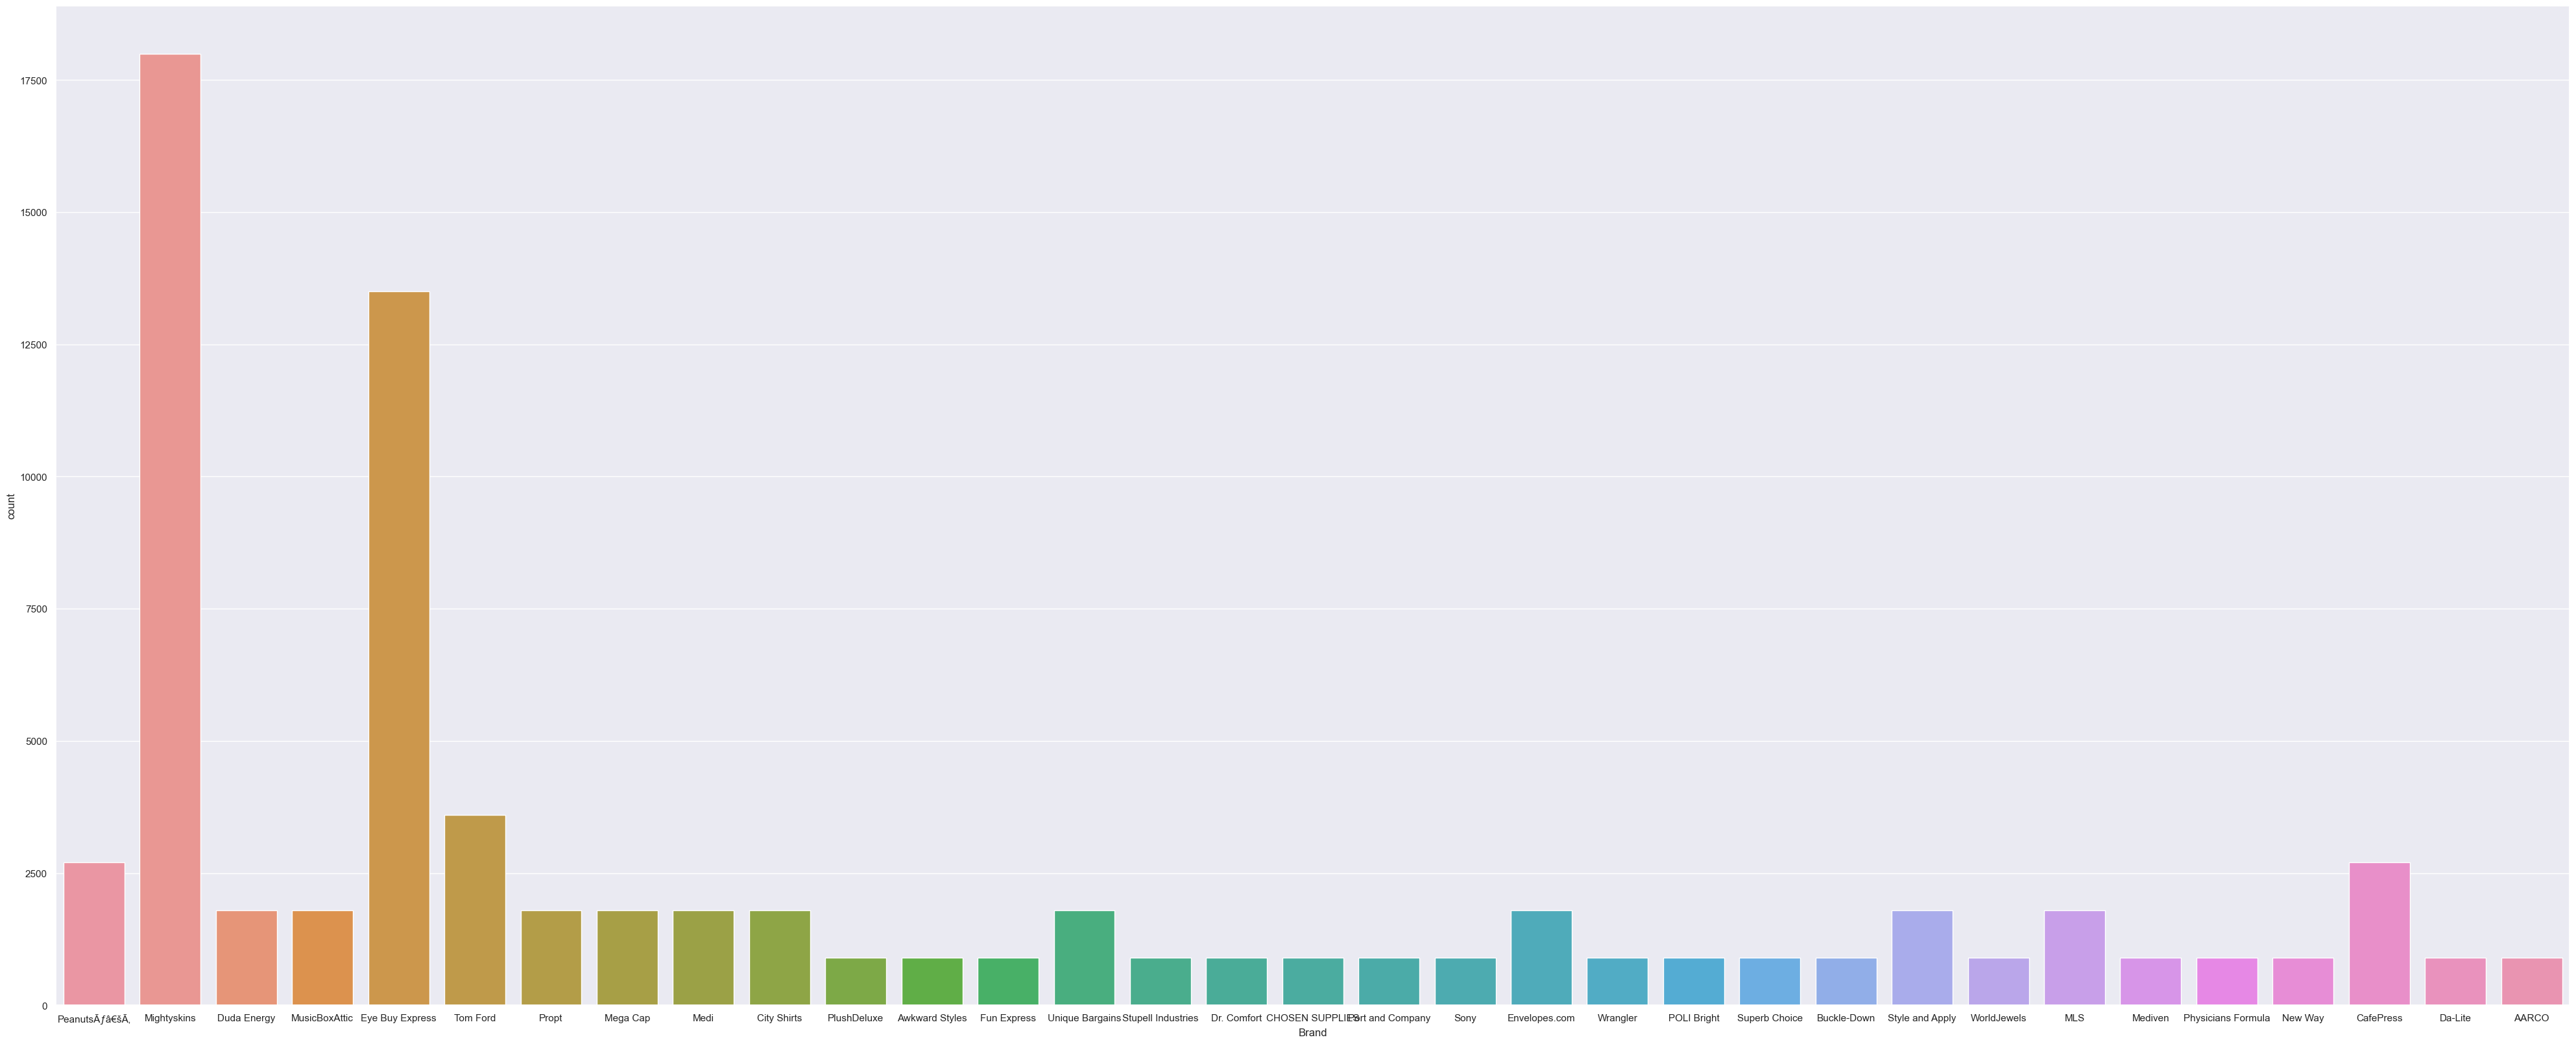

In [27]:
# Count of Brand Category
plt.figure(figsize=(50,20))
sns.set_theme(style="darkgrid")
sns.countplot(x = 'Brand', data = final_data1)

<Axes: xlabel='Income', ylabel='count'>

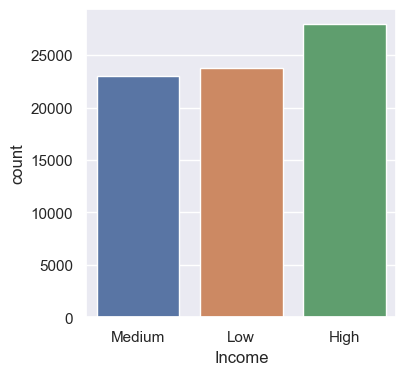

In [28]:
# Count of Income Category
plt.figure(figsize=(4,4))
sns.set_theme(style="darkgrid")
sns.countplot(x = 'Income', data = final_data1)

<Axes: xlabel='Age', ylabel='Count'>

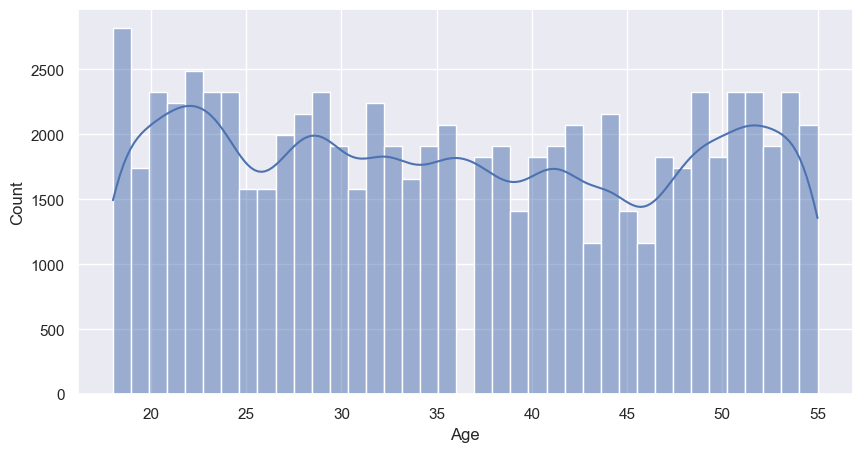

In [29]:
# histogram plot to show distribution age
plt.figure(figsize=(10,5))
sns.set_theme(style="darkgrid")
sns.histplot(data=final_data1, x="Age", kde = True)

<Axes: xlabel='Age', ylabel='Count'>

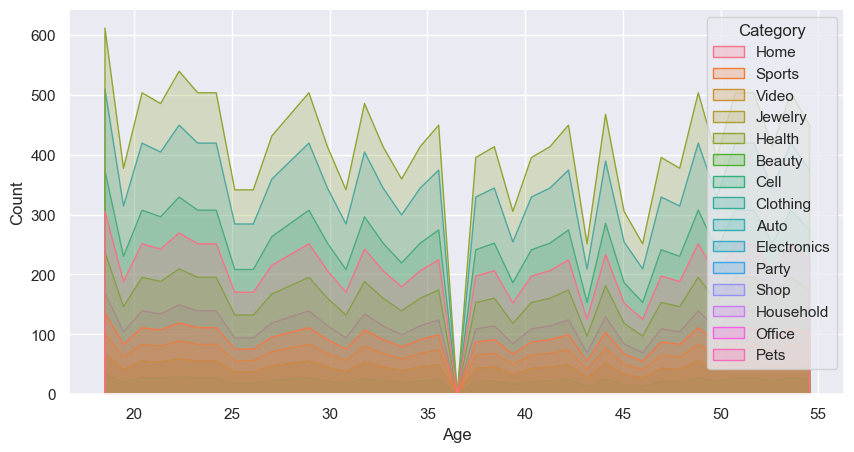

In [30]:
# histogram plot to show distribution age by category
plt.figure(figsize=(10,5))
sns.set_theme(style="darkgrid")
sns.histplot(data=final_data1, x="Age", hue="Category", element= "poly")

<Axes: xlabel='flag_buy', ylabel='count'>

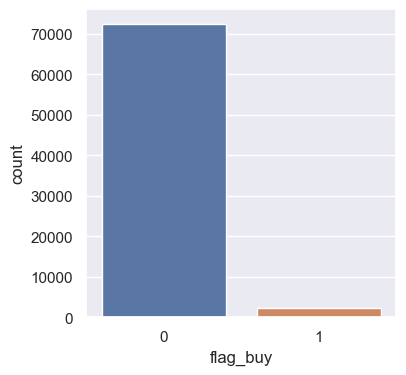

In [31]:
# Count plot to show number of customer bought the product
plt.figure(figsize=(4,4))
sns.set_theme(style="darkgrid")
sns.countplot(x = 'flag_buy', data = final_data1)

# Model Building

Let’s encode all the categorical variables before building the model. Also, store the stock code for further usage.

In [32]:
#Encoding categorical variable using Label Encoder

from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()
final_data1['StockCode'] = label_encoder.fit_transform(final_data1['StockCode'])

mappings = {}
mappings['StockCode'] = dict(zip(label_encoder.classes_,range(len(label_encoder.classes_))))

final_data1['Gender'] = label_encoder.fit_transform(final_data1['Gender'])
final_data1['Customer Segment'] = label_encoder.fit_transform(final_data1['Customer Segment'])
final_data1['Brand'] = label_encoder.fit_transform(final_data1['Brand'])
final_data1['Category'] = label_encoder.fit_transform(final_data1['Category'])
final_data1['Income'] = label_encoder.fit_transform(final_data1['Income'])

final_data1.head()

,CustomerID,Gender,Age,Income,Customer Segment,StockCode,Quantity,Brand,Unit Price,Category,flag_buy
0,14646,1,45,2,0,3,0,20,9999.99,6,0
1,14646,1,45,2,0,3,0,20,9999.99,6,0
2,14646,1,45,2,0,3,0,20,9999.99,6,0
3,14646,1,45,2,0,12,0,16,29.99,13,0
4,14646,1,45,2,0,39,0,16,14.99,14,0


### Train-Test Split

The data is split into two parts: one for training the model, which is the training set, and another for evaluating the model, which is the test set. `The train_test_split` library from `sklearn.model_selection` is imported to split the DataFrame into two parts.

In [33]:
## separating dependent and independent variables
x = final_data1.drop(['flag_buy'], axis = 1)
y = final_data1['flag_buy']

# check the shape of dependent and independent variable
print((x.shape, y.shape))

# splitting data into train and test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.6, random_state = 42)

((74700, 10), (74700,))


### Logistic Regression

Linear regression is needed to predict a numerical value. But you also encounter classification problems where dependent variables are binary, like yes or no, 1 or 0, true or false, and so on. In that case, logistic regression is needed.

In [34]:
#training using logistic regression

from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression()
logistic.fit(x_train, y_train)

LogisticRegression()

In [35]:
# calculate score

pred=logistic.predict(x_test)

print(confusion_matrix(y_test, pred))

[[28989     0]
 [    6   885]]


In [36]:
print(accuracy_score(y_test, pred))

0.9997991967871486


In [37]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28989
           1       1.00      0.99      1.00       891

    accuracy                           1.00     29880
   macro avg       1.00      1.00      1.00     29880
weighted avg       1.00      1.00      1.00     29880



Let’s apply a sampling technique, make it balanced data, and then build the model.

In [38]:
# Sampling technique to handle imbalanced data

from imblearn.combine import SMOTETomek
from collections import Counter

# Sampling technique to handle imbalanced data
smk = SMOTETomek(sampling_strategy=0.50)
X_res, y_res = smk.fit_resample(x_train, y_train)

# Count the number of classes
print("The number of classes before fit {}".format(Counter(y_train)))
print("The number of classes after fit {}".format(Counter(y_res)))

The number of classes before fit Counter({0: 43553, 1: 1267})
The number of classes after fit Counter({0: 43473, 1: 21696})


In [39]:
# Training model with Logistics Regression

from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression()
logistic.fit(X_res, y_res)

LogisticRegression()

In [40]:
# Calculate Score
y_pred=logistic.predict(x_test)

print(confusion_matrix(y_test,y_pred))

[[28989     0]
 [    2   889]]


In [41]:
print(accuracy_score(y_test,y_pred))

0.9999330655957162


In [42]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28989
           1       1.00      1.00      1.00       891

    accuracy                           1.00     29880
   macro avg       1.00      1.00      1.00     29880
weighted avg       1.00      1.00      1.00     29880



### Decision Tree

The decision is a type of supervised learning in which the data is split into similar groups based on the most important variable to the least.

In [43]:
##Training model using decision tree
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(X_res, y_res)
y_pred = dt.predict(x_test)
print(dt.score(x_train, y_train))

1.0


In [44]:
print(confusion_matrix(y_test,y_pred))

[[28989     0]
 [    0   891]]


In [45]:
print(accuracy_score(y_test,y_pred))

1.0


In [46]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28989
           1       1.00      1.00      1.00       891

    accuracy                           1.00     29880
   macro avg       1.00      1.00      1.00     29880
weighted avg       1.00      1.00      1.00     29880



### Random Forest

Random forest is the most widely used machine learning algorithm because of its flexibility and ability to overcome the overfitting problem. A random forest is an ensemble algorithm that is an ensemble of multiple decision trees. The higher the number of trees, the better the accuracy.

In [47]:
##Training model using Random forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_res, y_res)

# Calculate Score
y_pred=rf.predict(x_test)
print(confusion_matrix(y_test,y_pred))

[[28989     0]
 [    0   891]]


In [48]:
print(accuracy_score(y_test,y_pred))

1.0


In [49]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28989
           1       1.00      1.00      1.00       891

    accuracy                           1.00     29880
   macro avg       1.00      1.00      1.00     29880
weighted avg       1.00      1.00      1.00     29880



### KNN

In [50]:
#Training model using KNN
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.neighbors import KNeighborsClassifier

model1 = KNeighborsClassifier(n_neighbors=3)
model1.fit(X_res,y_res)
y_predict = model1.predict(x_test)

# Calculate Score
print(model1.score(x_train, y_train))

0.9901829540383758


In [51]:
print(confusion_matrix(y_test,y_predict))

[[28352   637]
 [  256   635]]


In [52]:
print(accuracy_score(y_test,y_predict))

0.9701137884872825


In [53]:
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98     28989
           1       0.50      0.71      0.59       891

    accuracy                           0.97     29880
   macro avg       0.75      0.85      0.79     29880
weighted avg       0.98      0.97      0.97     29880



The ROC (receiver operating characteristic) curve is an evaluation metric for classification tasks. A plot with a false positive rate on the x
axis and a true positive rate on the y axis is the ROC curve plot. It says how strongly the classes are distinguished when the thresholds are
varied. Higher the value of the area under the ROC curve, the higher the predictive power.

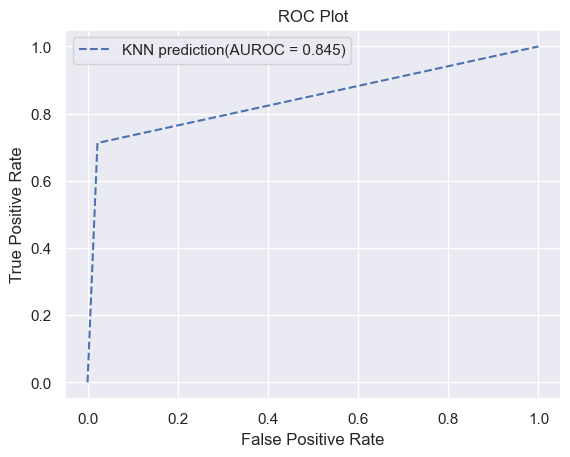

In [54]:
# plot AUROC curve
r_auc = roc_auc_score(y_test, y_predict)
r_fpr, r_tpr, _ = roc_curve(y_test, y_predict)
plt.plot(r_fpr, r_tpr, linestyle='--', label='KNN prediction(AUROC = %0.3f)' % r_auc)
plt.title('ROC Plot')

# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Show legend
plt.legend()

# Show plot
plt.show()

Let’s recommend the products to one customer.

In [57]:
# x_test has all the features, lets us take the copy of it
test_data = x_test.copy()

#let us store predictions in one variable
test_data['predictions'] = pred

#filter the data and recommend
recomm_one_cust = test_data[(test_data['CustomerID']== 14646) & (test_data['predictions']== 1)]

# to build the model we have encoded the stockcode column now we will decode and recommend
items = []
for item_id in recomm_one_cust['StockCode'].unique().tolist():
    prod = {v: k for k, v in mappings['StockCode'].items()}[item_id]
    items.append(str(prod))
items

['POST', '84997B', '84970L', '84459A']

These are the product IDs that should be recommended for customer 15810. If you want recommendations with product names, filter these IDs in the
product table.

In [58]:
recommendations = []
for i in items:
    recommendations.append(prod_df[prod_df['StockCode']== i]['Product Name'])
recommendations

[7    MightySkins Skin Decal Wrap Compatible with Ot...
 Name: Product Name, dtype: object,
 469    Awkward Styles Sugar Skull Shirts for Men Joll...
 Name: Product Name, dtype: object,
 1282    Eye Buy Express Kids Childrens Reading Glasses...
 Name: Product Name, dtype: object,
 1593    Ebe Reading Glasses Mens Womens Blue Silver Te...
 Name: Product Name, dtype: object]